# Data processing

Subset 5 consists of external samples.

In [1]:
! rsync -a /kaggle/input/mmdetection-v280/mmdetection /
! pip install /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
! pip install /kaggle/input/hpapytorchzoo/pytorch_zoo-master/
! pip install /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation/
! pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

! cp -r /kaggle/input/kgl-humanprotein-data/kgl_humanprotein_data /
! cp -r /kaggle/input/humanpro/kgl_humanprotein /

import sys
sys.path.append('/kgl_humanprotein/')

Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272907 sha256=fe35af9d3fa08194e0e794370a60aa56b4f27e934ee4cd4f7d0a7b8a31eb7bb3
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
Processing /kaggle/input/hpapytorchzoo/pytorch_zoo-master
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=e1676013b0c5ce2f6820f4f0316037a321b73bbaae9baa10dbac79bcf8661f7e
  Stored in directory: /root/.cache/pip/wheels/7f/18/21/aff5a8914e22461b2b025a9629c2b70464c36183caaf12bc09
Successfully built pytorch-zoo
Processing /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14815 sha256=aab92d85b823386ef9f802fda8f60dbdfbdc9fe6488502216f5f14fb80728794
  Stored in di

In [2]:
from pathlib import Path
import multiprocessing
import shutil
import zipfile
import numpy as np
import pandas as pd
import cv2
import pycocotools.mask as mutils
import matplotlib.pyplot as plt

from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.config.config import *
from kgl_humanprotein.data_process import *

run on 774c74c165df


In [3]:
%cd /kaggle

/kaggle


In [4]:
dir_img = Path('/kaggle/input/humanpro-publichpa-grey/publichpa/')

In [5]:
imgids = list(set('_'.join(pth.name.split('_')[:-1]) for pth in dir_img.ls()))

In [6]:
df_img = pd.read_feather('/kaggle/input/humanpro-publichpa-1/publichpa.feather')
df_img['Id'] = df_img.Image.apply(lambda o: o.split('/')[-1])
df_img = df_img[df_img.Id.isin(imgids)].reset_index(drop=True)

In [7]:
dir_mask = Path('/kaggle/input/humanpro-publichpa-1-masks/publichpa_masks')

# Segmentation masks ---> RLEs, bboxes.

In [8]:
%%time

imgids = imgids[:]

def isplit_img2cells(i):
    imgid = imgids[i]
    pth_mask = dir_mask/f'{imgid}_predictedmask.png'
    mask = cv2.imread(str(pth_mask), cv2.IMREAD_UNCHANGED)
    rles = mask2rles(mask)
    bboxes = rles2bboxes(rles)
    ids = [f'{imgid}_{i}' for i in range(len(bboxes))]
    df = pd.DataFrame({'Id':ids, 'rle':rles, 'bbox':list(bboxes)})
    df['Target'] = df_img.set_index('Id').loc[imgid, 'Label_idx']
    return imgid, df

cpu_count = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpu_count) as pool:
    df_cells = pd.DataFrame()
    for imgid, df in pool.imap(isplit_img2cells, range(len(imgids))):
        print(f'\rProcessed image {imgid}', end='')
        df_cells = df_cells.append(df, ignore_index=True)

Processed image 1247_C12_1CPU times: user 13.1 s, sys: 1.23 s, total: 14.3 s
Wall time: 19min 42s


In [9]:
1963 / 10 * 5.59 / 60**2

0.3048102777777778

In [10]:
df_cells.head()

,Id,rle,bbox,Target
0,183_B3_2_0,"{'size': [1728, 1728], 'counts': b'V2d1\\d10O1...","[0.0, 0.0, 154.0, 122.0]",0|3|10
1,183_B3_2_1,"{'size': [1728, 1728], 'counts': b'P\\Zj18he11...","[1106.0, 0.0, 1542.0, 330.0]",0|3|10
2,183_B3_2_2,"{'size': [1728, 1728], 'counts': b'm`Sk0a0^e12...","[514.0, 98.0, 902.0, 362.0]",0|3|10
3,183_B3_2_3,"{'size': [1728, 1728], 'counts': b'QihW17he12N...","[754.0, 294.0, 1230.0, 706.0]",0|3|10
4,183_B3_2_4,"{'size': [1728, 1728], 'counts': b'dWQ:c0\\e12...","[190.0, 338.0, 574.0, 714.0]",0|3|10


# Crop out cells
Save to disk and record max value in each color channel.

In [11]:
def get_max_rgby(img):
    return np.array([np.max(img[...,i]) for i in range(img.shape[-1])])

In [12]:
%%time

crop_sz = 384
dir_train = Path('/kaggle/train')
dir_cell = dir_train / f'images_{crop_sz}'

def icrop_cell(i):
    r = df_cells.iloc[i]
    
    imgid = '_'.join(r.Id.split('_')[:-1])
    img = load_RGBY_image(dir_img, imgid)
    
    bmask = mutils.decode(r.rle)
    crop = crop_image(img, r.bbox, bmask=bmask)
    crop = pad_to_square(crop)
    crop = resize_image(crop, crop_sz)
    save_image(dir_cell, r.Id, crop)
    
    chmax = get_max_rgby(crop)
    return r.Id, chmax


dir_cell.mkdir(exist_ok=True, parents=True)

# 1. Crop out each cell and save to disk.
# 2. Record the max value in each channel.
cpu_count = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpu_count) as pool:
    chmaxs = []
    for cellid, chmax in pool.imap(icrop_cell, range(len(df_cells))):
        print(f'\rCropped cell {cellid}', end='')
        chmaxs.append(chmax)
        
chmaxs = np.array(chmaxs)

Cropped cell 1247_C12_1_11CPU times: user 35.4 s, sys: 6.28 s, total: 41.7 s
Wall time: 41min 51s


In [13]:
1963 / 10 * 9.3 / 60**2

0.5071083333333334

In [14]:
df_cells[['max_red', 'max_green', 'max_blue', 'max_yellow']] = chmaxs

In [15]:
df_cells.to_feather(dir_train/'train.feather')

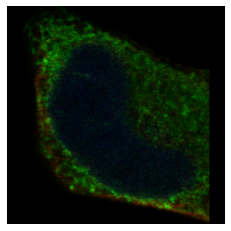

In [16]:
plt.imshow(load_RGBY_image(dir_cell, df_cells.Id.iloc[104])[...,[0,3,2]]); plt.axis('off');

In [17]:
isubset = 5  

%cd /kaggle
! mkdir humanpro_train_cells_subset{isubset}
! mv train humanpro_train_cells_subset{isubset}/.
! zip -qr humanpro_train_cells_subset{isubset}.zip humanpro_train_cells_subset{isubset}/
! cp humanpro_train_cells_subset{isubset}.zip /kaggle/working
%cd /kaggle

/kaggle
/kaggle
